<a href="https://colab.research.google.com/github/saurabhmathur96/Speech-to-Text-Engine/blob/master/accent_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/gdrive')
%cd /gdrive

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /gdrive
/gdrive


In [3]:
import zipfile
import sys
from os import path, listdir

base = 'My Drive'

zipfile.ZipFile(path.join(base, 'speech-accent-archive.zip')).extractall('..')
listdir()

['My Drive', '.Trash']

In [4]:
import pandas as pd


df = pd.read_csv('../speakers_all.csv')
df = df[df['file_missing?'] == False]
df.head()

,age,age_onset,birthplace,filename,native_language,sex,speakerid,country,file_missing?,Unnamed: 9,Unnamed: 10,Unnamed: 11
32,27.0,9.0,"virginia, south africa",afrikaans1,afrikaans,female,1,south africa,False,NaN,NaN,NaN
33,40.0,5.0,"pretoria, south africa",afrikaans2,afrikaans,male,2,south africa,False,NaN,NaN,NaN
34,43.0,4.0,"pretoria, transvaal, south africa",afrikaans3,afrikaans,male,418,south africa,False,NaN,NaN,NaN
35,26.0,8.0,"pretoria, south africa",afrikaans4,afrikaans,male,1159,south africa,False,NaN,NaN,NaN
36,19.0,6.0,"cape town, south africa",afrikaans5,afrikaans,male,1432,south africa,False,NaN,NaN,NaN


In [5]:
from collections import Counter

df['target'] = [f'{row.sex}-{row.country}-{row.native_language}' for i, row in df.iterrows() ]
accents, counts = zip(*Counter(df.target).most_common(10))
accents

[('male-usa-english', 189),
 ('female-usa-english', 184),
 ('male-uk-english', 41),
 ('female-china-mandarin', 33),
 ('male-canada-english', 27),
 ('female-south korea-korean', 27),
 ('female-uk-english', 24),
 ('male-south korea-korean', 23),
 ('male-saudi arabia-arabic', 22),
 ('male-italy-italian', 22),
 ('male-turkey-turkish', 21),
 ('female-belgium-dutch', 20),
 ('male-brazil-portuguese', 20),
 ('male-china-mandarin', 19),
 ('female-brazil-portuguese', 19),
 ('male-australia-english', 18),
 ('male-poland-polish', 18),
 ('female-canada-english', 17),
 ('female-japan-japanese', 17),
 ('female-macedonia-macedonian', 17),
 ('female-germany-german', 16),
 ('female-poland-polish', 16),
 ('female-china-cantonese', 14),
 ('female-australia-english', 14),
 ('male-france-french', 14),
 ('male-russia-russian', 14),
 ('female-turkey-turkish', 14),
 ('female-france-french', 13),
 ('female-russia-russian', 13),
 ('female-colombia-spanish', 13),
 ('male-vietnam-vietnamese', 13),
 ('male-bolivia-

In [7]:
from os import path
from glob import glob
import librosa 
import numpy as np         
from tqdm.auto import tqdm
 
base = '../recordings/recordings'
x = []
y = []

for t, accent in tqdm(enumerate(accents), total=len(accents)):
  for fpath in df[df['target']==accent].filename.values:
    sound, rate = librosa.load(path.join(base, f'{fpath}.mp3')) 
    n = len(sound)
    chunksize = 22050*2
    for i in range(0, n-chunksize, chunksize):
      x.append (np.abs(librosa.stft(sound[i:i+chunksize], n_fft=1024, hop_length=512)).T)
      y.append(t)

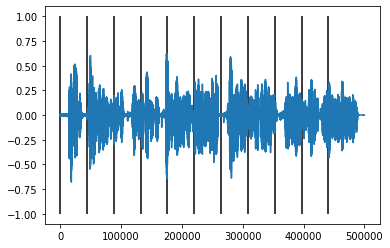

In [8]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.plot(sound)
plt.vlines([i for i in range(0, len(sound)-chunksize, chunksize)], -1, 1)

In [0]:
from sklearn.model_selection import train_test_split
import torch

x1 = np.stack(x)
y1 = np.stack(y)

x_train, x_test, y_train, y_test = train_test_split(x1, y1, stratify=y1)

train = torch.utils.data.TensorDataset(torch.from_numpy(x_train), torch.from_numpy(y_train))
train_loader = torch.utils.data.DataLoader(train, batch_size = 128, shuffle=True)

test = torch.utils.data.TensorDataset(torch.from_numpy(x_test), torch.from_numpy(y_test))
test_loader = torch.utils.data.DataLoader(test, batch_size = 128, shuffle=True)

In [10]:
import torch
import torch.nn as nn 
import torch.nn.functional as F
from tqdm.auto import tqdm

class Net(nn.Module):
  def __init__(self):
    super(Net, self).__init__()
    self.hidden_size = 128
    self.num_layers = 2
    self.lstm =  nn.LSTM(513, self.hidden_size, num_layers=self.num_layers, batch_first=True)
    self.linear = nn.Linear(self.num_layers * self.hidden_size, len(accents))

  def forward(self, x):
    h_t = torch.zeros(self.num_layers, x.size(0), self.hidden_size)
    c_t = torch.zeros(self.num_layers, x.size(0), self.hidden_size)
    
    h_lstm, _ = self.lstm(x, (h_t, c_t))
    # print (h_lstm.shape)
    avg_pool = torch.mean(h_lstm, 1)
    max_pool, _ = torch.max(h_lstm, 1)
    conc = torch.cat(( avg_pool, max_pool), 1)
    # print (conc.shape)
    encoded = self.linear(conc).view(-1, len(accents))
    return encoded
    # return torch.softmax(encoded, 1)

import torch.nn.init as init

def weight_init(m):
  if isinstance(m, nn.Linear):
    init.xavier_normal_(m.weight.data)
    init.normal_(m.bias.data)
  elif isinstance(m, nn.LSTM):
    for param in m.parameters():
      if len(param.shape) >= 2:
        init.orthogonal_(param.data)
      else:
        init.normal_(param.data)


net = Net()
net.apply(weight_init)


Net(
  (lstm): LSTM(513, 128, num_layers=2, batch_first=True)
  (linear): Linear(in_features=256, out_features=10, bias=True)
)

In [11]:
c = Counter(y_train)
weights = []
for i in range(10):
  weights.append(1/c[i])
weights = np.array(weights)
weights = weights / np.sum(weights)
weights

array([0.02056803, 0.02082547, 0.09464989, 0.07786469, 0.1470375 ,
       0.10230764, 0.15806531, 0.12300802, 0.10863595, 0.1470375 ])

In [12]:
net = Net()
net.apply(weight_init)

optimizer = torch.optim.Adam(net.parameters(), lr=1e-3, weight_decay=0.0001)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.9999)
criterion = nn.CrossEntropyLoss(weight=torch.Tensor(weights))

train_losses = []
train_scores = []
for _ in range(10):
  for inputs, targets in tqdm(train_loader):
    optimizer.zero_grad()
    output = net(inputs)
    p = torch.argmax(torch.softmax(output, 1), 1)
    score = torch.mean((p == targets).float())
    train_scores.append(score)
    loss = criterion(output, targets)
    train_losses.append(loss.item())
    loss.backward()
    optimizer.step()
    scheduler.step()
  print ('Train loss =', np.mean(train_losses))
  print ('Train score =', np.mean(train_scores))

  with torch.no_grad():
    test_scores = []
    for inputs, targets in tqdm(test_loader):
      
      output = net(inputs)

      p = torch.argmax(torch.softmax(output, 1), 1)
      score = torch.mean((p == targets).float())
      test_scores.append(score.item())
    print ('Test score =', np.mean(test_scores), end='\n\n')


Train loss = 2.2392257224945795
Train score = 0.15994835



Test score = 0.16749700797455652




Train loss = 1.9844568896861303
Train score = 0.20937829



Test score = 0.23809715573276793




Train loss = 1.8320154850445096
Train score = 0.2462141



Test score = 0.3981383464166096




Train loss = 1.7202613268579756
Train score = 0.28390613



Test score = 0.3816446512937546




Train loss = 1.6198231242951893
Train score = 0.31719843



Test score = 0.4341632915394647




Train loss = 1.5298839769666157
Train score = 0.346511



Test score = 0.47809278326375143




Train loss = 1.4428065311746532
Train score = 0.37580502



Test score = 0.47101666033267975




Train loss = 1.36223020209443
Train score = 0.40257353



Test score = 0.5821980834007263




Train loss = 1.2846847373657126
Train score = 0.42967656



Test score = 0.5522194845335824




Train loss = 1.2131413180913244
Train score = 0.45482206



Test score = 0.5644732585975102



[512. 506. 112. 136.  72. 103.  67.  85.  97.  71.]


(-0.5, 9.5, 9.5, -0.5)

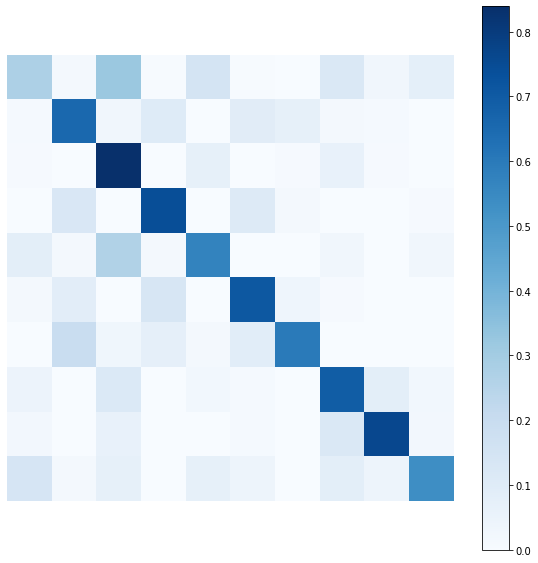

In [13]:
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels

np.set_printoptions(precision=2)

with torch.no_grad():
  p = torch.argmax(net(torch.from_numpy(x_test)), 1).int().numpy()

cm = confusion_matrix(y_test, p).astype(float)
print(cm.sum(axis=1))
for i in range(10):
  cm[i] /= cm[i].sum()

plt.figure(figsize=(10, 10))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.colorbar()
plt.axis('off')